In [3]:
%matplotlib notebook

# %qtconsole

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes as qc
from qcodes.dataset.experiment_container import new_experiment

In [4]:
from pytopo.qctools import instruments as instools
from pytopo.qctools.instruments import create_inst, add2station

from pytopo.sweep.base import Nest, Chain
from pytopo.sweep.decorators import getter, setter
from pytopo.sweep import sweep, do_experiment, hardsweep, measure

# Define measurement functions

In [5]:
def setup_frq_sweep(fstart, fstop, fpts, chan='S21', bw=None, navgs=None, pwr=None):
    """
    Setup a VNA trace.
    
    assumes that a channel with name chan is already created.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(fstart, fstop, fpts)
    trace.start(fstart)
    trace.stop(fstop)
    trace.npts(fpts)
    if navgs is not None:
        trace.avg(navgs)
    if bw is not None:
        trace.bandwidth(bw)
    if pwr is not None:
        trace.power(pwr)
    trace.autoscale()
    
    if not vna.rf_power():
        vna.rf_on()
    
    return fvals

def take_trace(chan='S21', plot=False):
    """
    Get the data of a currently measured trace.
    The trace has to be setup already.
    
    Returns magnitude (in dB) and phase (in rad).
    
    If plot is true, make a simple plot of the magnitude vs frequency.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(trace.start(), trace.stop(), trace.npts())
    mag, phase = trace.trace_mag_phase()
    
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(fvals*1e-9, 20*np.log10(mag))
        ax.grid(dashes=[1,1])
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Magnitude (dBm)')
        
    return mag, phase


@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('amplitude', '', 'array'), ('phase', 'rad', 'array')]
)
def vna_frequency_sweep(*arg, **kw):
    """
    Measurement function for a simple VNA trace for pytopo.sweep.
    
    All arguments will be passed to setup_trace.
    Return data is as returned by take_trace.
    """
    fvals = setup_frq_sweep(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return fvals, np.vstack((mag, phase))


@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('magnitude', 'dB', 'array'), ('phase', 'rad', 'array')]
)
def vna_frequency_sweep_dB(*arg, **kw):
    """
    Measurement function for a simple VNA trace for pytopo.sweep.
    
    All arguments will be passed to setup_trace.
    Return data is as returned by take_trace.
    """
    fvals = setup_frq_sweep(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return fvals, np.vstack((20*np.log10(mag), phase))


def setup_zerospan_trace(frq, npts, chan='S21', span=1.):
    """
    Setup the VNA to measure a trace around <frq> with <npts> samples
    in a very narray frequency span.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    trace.center(frq)
    trace.span(span)
    trace.npts(npts)
    
    trace.autoscale()
    
    if not vna.rf_power():
        vna.rf_on()


@hardsweep(
    ind=[('iteration', '', 'array')], 
    dep=[('amplitude', '', 'array'), ('phase', 'rad', 'array')]
)
def vna_timetrace(*arg, **kw):
    """
    Measure a 'time trace', emulated by a narrow span trace with many points.
    """
    setup_zerospan_trace(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return np.arange(mag.size), np.vstack((mag, phase))


@hardsweep(
    ind=[('iteration', '', 'array')], 
    dep=[('magnitude', 'dB', 'array'), ('phase', 'rad', 'array')]
)
def vna_timetrace(*arg, **kw):
    """
    Measure a 'time trace', emulated by a narrow span trace with many points.
    """
    setup_zerospan_trace(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return np.arange(mag.size), np.vstack((20*np.log10(mag), phase))

# Init station

## Global variables

In [6]:
SAMPLE = "181002_67_d2_CD20190121"

## Init instruments

In [7]:
%run -i "D:\OneDrive\BF2\Code\BF2\BF2\init_station_cqedVNA.py"

Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101971, firmware:2.90) in 0.73s
Initialized IVVI-rack in 0.04s


In [8]:
numdacs = int(station.ivvi._numdacs)
for i in range(1, numdacs+1):
    station.ivvi.parameters['dac{}'.format(i)].set_step(10)
    station.ivvi.parameters['dac{}'.format(i)].set_delay(0.001)

AttributeError: 'Parameter' object has no attribute 'set_step'

In [ ]:
from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
keysight = create_inst(
    Keysight_34465A, 'keysight', address='TCPIP::169.254.4.61::inst0::INSTR', force_new_instance=True)
add2station(station, keysight)


In [29]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
yoko = create_inst(
    GS200, 'yoko', address='TCPIP::169.254.1.9::inst0::INSTR', force_new_instance=True)
add2station(station, yoko)

Connected to: YOKOGAWA GS210 (serial:91T926459, firmware:2.02) in 0.05s


[yoko(GS200)] Snapshot: Could not update parameter: current_range
[yoko(GS200)] Snapshot: Could not update parameter: current


In [54]:
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
TWPA = instools.create_inst(RohdeSchwarz_SGS100A, 'TWPA', address="TCPIP0::169.254.167.18", force_new_instance=True)
add2station(station, TWPA)

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110531, firmware:3.1.19.15-3.50.124.67) in 0.05s


# Setup specific tools

In [9]:
station.ivvi.set_dacs_zero()

In [ ]:
station.ivvi.dac14()

In [10]:
dac_cutter1 = station.ivvi.dac1
dac_cutter14= station.ivvi.dac2
dac_plunger3 = station.ivvi.dac7
dac_plunger7 = station.ivvi.dac4
dac_plunger16 = station.ivvi.dac5
dac_plunger20 = station.ivvi.dac6

@setter(('cutters', 'mV'),)
def set_cutters(val):
    """
    Set both cutters (on all devices) to val (in mV).
    """
    dac_cutter1(val)
    dac_cutter14(val)
    return val


@setter(('plungers_16_20', 'mV'),)
def set_plungers_a(val):
    """
    Set all plungers to val (in mV).
    """
    dac_plunger16(val)
    dac_plunger20(val)
    return val

@setter(('plungers_3_20', 'mV'),)
def set_plungers_b(val):
    """
    Set all plungers to val (in mV).
    """
    dac_plunger3(val)
    dac_plunger20(val)
    return val

@setter(('plungers_7_3', 'mV'),)
def set_plungers_d(val):
    """
    Set all plungers to val (in mV).
    """
    dac_plunger7(val)
    dac_plunger3(val)
    return val

@setter(('plungers_7_16', 'mV'),)
def set_plungers_c(val):
    """
    Set all plungers to val (in mV).
    """
    dac_plunger16(val)
    dac_plunger7(val)
    return val


@setter(('flux_A', 'V'),)
def set_flux(val):
    """
    Set yoko to val (in V).
    """
    yoko.voltage(val)
    return val

## Using the Oxford power supply with the AMI magnet

In [ ]:

xconvert = 68.3/station.mgnt.GRPX.ATOB()
yconvert = 67.7/station.mgnt.GRPY.ATOB()
zconvert = 11.96/station.mgnt.GRPZ.ATOB()

@setter(('magnet_x', 'T'),) 
def set_magnet_x(val):
    """
    Set magnet x
    """
    realxval = xconvert*val
    station.mgnt.x_target(realxval)
    station.mgnt.ramp(mode='safe')
    return val

@setter(('magnet_y', 'T'),)
def set_magnet_y(val):
    """
    Set magnet y
    """
    realyval = yconvert*val
    station.mgnt.y_target(realyval)
    station.mgnt.ramp(mode='safe')
    return val

@setter(('magnet_z', 'T'),)
def set_magnet_z(val):
    """
    Set magnet z
    """
    realzval = zconvert*val
    station.mgnt.z_target(realzval)
    station.mgnt.ramp(mode='safe')
    return val

# VNA measurements

In [11]:
# the VNA driver has some weird default settings. 
# Make sure here that we measure what we want
station.vna.clear_channels()
station.vna.add_channel('S21')
station.vna.rf_off()

<IPython.core.display.Javascript object>


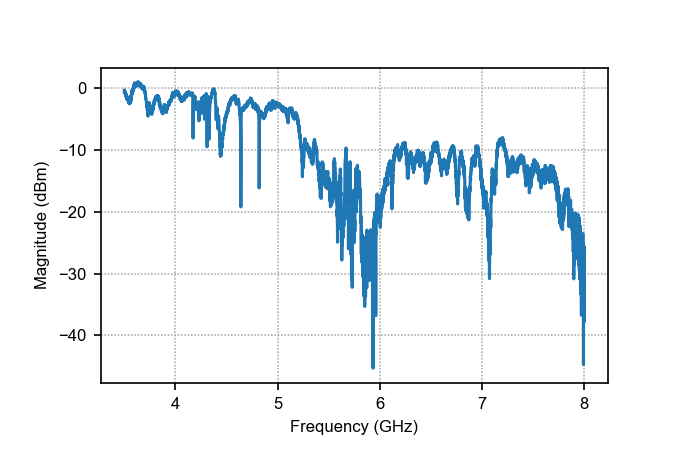

In [82]:
#check that we can take the trace correctly
setup_frq_sweep(3.5e9, 8.0e9, 4501, bw=1e3, navgs=1, pwr=-55)
mag, phase = take_trace(plot=True)

In [ ]:
setup_frq_sweep(3.5e9, 5.5e9, 2301, bw=1e3, navgs=1, pwr=-55)
mag, phase = take_trace(plot=True)
#plt.xlim(3.95e9,3.97e9)

In [ ]:
dac_cutter14(0)

In [ ]:
keysight.volt()

# Testing

## Quick manual trace (without saving)

In [ ]:
setup_frq_sweep(fstart=3.9e9, fstop=3.98e9, fpts=801, pwr=-55)
mag, phase = take_trace(plot=True)

# Take a single VNA trace

In [ ]:
dac_cutter1(), dac_cutter14(), dac_plunger3(), dac_plunger7(), dac_plunger16(), dac_plunger20(), station.ivvi.dac7(), station.ivvi.dac8()

In [84]:
station.ivvi.set_dacs_zero()

In [78]:
#station.TWPA.off()
sweep_obj = vna_frequency_sweep_dB(fstart=4.0*1e9, fstop=6.0e9, fpts=5001, chan='S21', pwr=-55)

result = do_experiment(f"VNA/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 47


In [ ]:
station.TWPA.on()
sweep_obj = vna_frequency_sweep_dB(fstart=4.56*1e9, fstop=4.6*1e9, fpts=201, chan='S21', pwr=-60)

result = do_experiment(f"VNA/{SAMPLE}", sweep_obj, live_plot=True)

<IPython.core.display.Javascript object>


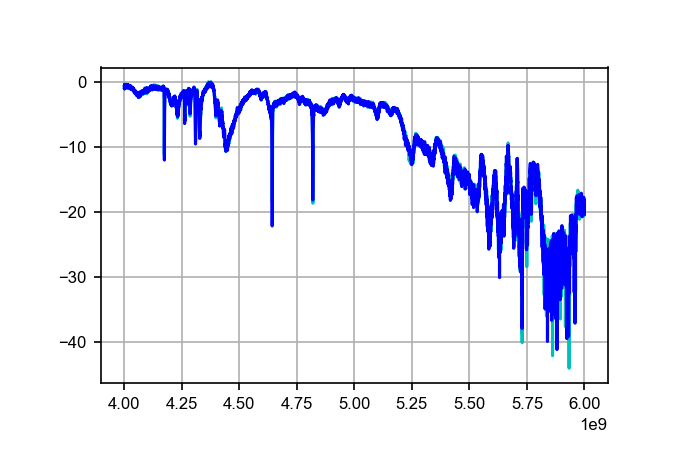

In [79]:
from qcodes import load_by_id
ds1 = load_by_id(44)
ds2 = load_by_id(47)
freqs1 = ds1.get_data('frequency')
mags1 = ds1.get_data('magnitude')
freqs2 = ds2.get_data('frequency')
mags2 = ds2.get_data('magnitude')
#mags1=np.reshape(mags1,(np.shape(mags1)[0],np.shape(mags1)[2]))

plt.figure(6)
for i in range(1):
    plt.plot(freqs2[i][0][:],mags2[i][0][:], 'c')
    plt.plot(freqs1[i][0][:],mags1[i][0][:], 'b')
    plt.grid()
#plt.xlim(3e9,7e9)


#plt.figure(7)
#plt.imshow(np.transpose(mags1)[-1:0:-1],aspect='auto',extent = [-500, 1800., freqs1[0][0][0],freqs1[0][0][-1]])

In [ ]:


mags1=np.reshape(mags1,(200,701))
np.shape(mags1)

# Sweep Gates and monitor with VNA

In [88]:
center_freqs = np.array([5.248])

for i,f in enumerate(center_freqs):
    cur_cutter = dac_cutter1()
    sweep_obj = sweep(dac_cutter1, np.arange(cur_cutter,-580.0,1.0))(
        vna_frequency_sweep_dB(fstart=(f-0.1)*1e9, fstop=(f+0.1)*1e9, fpts=2001, chan='S21')
    )
    result = do_experiment(f"VNA_gatesweep/{SAMPLE}", sweep_obj, live_plot=True)
    

Starting experimental run with id: 80


Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting it to 5148000000.0
Could not set start to 5148000000.000001 setting

In [51]:
center_freqs = np.array([4.577])
cur_cutter = dac_cutter1()

for i,f in enumerate(center_freqs):
    sweep_obj = sweep(set_cutters, np.arange(cur_cutter,-2000.0,-5.0))(
        vna_frequency_sweep_dB(fstart=5.2e9, fstop=5.3e9, fpts=1001, chan='S21', pwr=-55)
    )
    result = do_experiment(f"VNA_gatesweep/{SAMPLE}", sweep_obj, live_plot=True)
    

Starting experimental run with id: 31


In [ ]:
#station.ivvi.set_dacs_zero()
#dac_cutter14(-2000)
cur_cutter = dac_cutter14()
sweep_obj = sweep(dac_cutter14, np.arange(0.0,1000.0,1.0))(
    vna_frequency_sweep_dB(fstart=3.20e9, fstop=5.5e9, fpts=2301, chan='S21', pwr=-55)
    )

result = do_experiment(f"VNA_gatesweep/{SAMPLE}", sweep_obj, live_plot=True)

In [ ]:
dac_cutter14(-500)

In [ ]:
#station.ivvi.set_dacs_zero()
#dac_cutter14(-2000)
cur_cutter = dac_cutter14()
sweep_obj = sweep(dac_cutter14, np.arange(-500.0,1800.,0.2))(
    vna_frequency_sweep_dB(fstart=4.51e9, fstop=4.62e9, fpts=1501, chan='S21', pwr=-55)
    )

result = do_experiment(f"VNA_gatesweep/{SAMPLE}", sweep_obj, live_plot=True)

In [ ]:
dac_cutter14()

In [ ]:
#station.ivvi.set_dacs_zero()
#dac_cutter14(-2000)
cur_cutter = dac_cutter14()
sweep_obj = sweep(dac_cutter1, np.arange(-500.0,1800.,1.0))(
    vna_frequency_sweep_dB(fstart=4.70e9, fstop=4.77e9, fpts=601, chan='S21', pwr=-55)
    )

result = do_experiment(f"VNA_gatesweep/{SAMPLE}", sweep_obj, live_plot=True)

In [ ]:
station.ivvi.set_dacs_zero()

# Power dependence

In [ ]:
station.ivvi.set_dacs_zero()

In [ ]:
center_freqs = np.array([4.579])

for i,f in enumerate(center_freqs):
    sweep_obj = sweep(station.vna.S21.power, np.arange(-60., -20., 4.))(
        vna_frequency_sweep_dB(fstart=(f-0.04)*1e9, fstop=(f+0.025)*1e9, fpts=7001, chan='S21')
    )

    result = do_experiment(f"VNA_powersweep/{SAMPLE}", sweep_obj, live_plot=True)

# Flux dependence

In [32]:
station.yoko.current_range(0.1)

In [31]:
station.yoko.off()
station.yoko.source_mode('CURR')

In [33]:
station.yoko.current(0.00)


In [ ]:
station.yoko.current(0.00)
station.yoko.on()

sweep_obj = sweep(station.yoko.current, np.arange(5e-3, +10e-3, +0.005e-3))(
    vna_frequency_sweep_dB(fstart=3.935e9, fstop=3.945e9, fpts=501, chan='S21', pwr=-55)
    )

result = do_experiment(f"VNA_flux_sweep/{SAMPLE}", sweep_obj, live_plot=True)

In [89]:
station.yoko.current()

0.015709

In [99]:
dac_cutter1(550.0)

### Flux vs resonator frequency

In [98]:
station.yoko.on()
cur_current = station.yoko.current()
cur_cutter1 = dac_cutter1()
cutters = np.arange(-530.0,600.0,20.0)
for i in cutters:
    dac_cutter1(i)
    sweep_obj = sweep(station.yoko.current, np.arange(0.0, 0.04, 0.002/14.64))(
        vna_frequency_sweep_dB(fstart=5.2e9, fstop=5.3e9, fpts=1001, chan='S21', pwr=-55)
        )

    result = do_experiment(f"VNA_flux_sweep/{SAMPLE}", sweep_obj, live_plot=True)
    sweep_obj = sweep(station.yoko.current, np.arange(0.04, 0.0, -0.002/14.64))(
        vna_frequency_sweep_dB(fstart=5.1e9, fstop=5.2e9, fpts=1001, chan='S21', pwr=-55)
        )

    result = do_experiment(f"VNA_flux_sweep/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 133
Starting experimental run with id: 134
Starting experimental run with id: 135
Starting experimental run with id: 136
Starting experimental run with id: 137
Starting experimental run with id: 138
Starting experimental run with id: 139
Starting experimental run with id: 140
Starting experimental run with id: 141
Starting experimental run with id: 142
Starting experimental run with id: 143
Starting experimental run with id: 144
Starting experimental run with id: 145
Starting experimental run with id: 146
Starting experimental run with id: 147
Starting experimental run with id: 148
Starting experimental run with id: 149
Starting experimental run with id: 150
Starting experimental run with id: 151
Starting experimental run with id: 152
Starting experimental run with id: 153
Starting experimental run with id: 154
Starting experimental run with id: 155
Starting experimental run with id: 156
Starting experimental run with id: 157
Starting experimental run

In [77]:
station.yoko.on()
cur_current = station.yoko.current()
sweep_obj = sweep(station.yoko.current, np.arange(cur_current, 0.016, 0.005/14.64))(
    vna_frequency_sweep_dB(fstart=4.0e9, fstop=5.0e9, fpts=101, chan='S21', pwr=-55)
    )

result = do_experiment(f"VNA_flux_sweep/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 46


## 2D Cutter and flux

In [ ]:
station.yoko.on()
#This is to ramp down the current before starting 
cur_current = station.yoko.current()
sweep_obj = sweep(station.yoko.current, np.linspace(cur_current, 0.0, 50))(
    vna_frequency_sweep_dB(fstart=4.565e9-40e6, fstop=4.595e9, fpts=101, chan='S21', pwr=-55)
    )
result = do_experiment(f"VNA_flux_sweep/{SAMPLE}", sweep_obj, live_plot=True)


sweep_obj = sweep(station.yoko.current, np.arange(0.0, +9.0e-3, +0.1e-3))(
              sweep(dac_cutter14, np.arange(-100.,1700.,10.0))(
                vna_frequency_sweep_dB(fstart=4.53e9, fstop=4.57e9, fpts=701, chan='S21', pwr=-55)
                )
             )

result = do_experiment(f"VNA_flux_sweep/{SAMPLE}", sweep_obj, live_plot=True)


#This is to ramp down after finishing
cur_current = station.yoko.current()
sweep_obj = sweep(station.yoko.current, np.linspace(cur_current, 0.0, 50))(
    vna_frequency_sweep_dB(fstart=4.53e9-40e6, fstop=4.585e9, fpts=101, chan='S21', pwr=-55)
    )
result = do_experiment(f"VNA_flux_sweep/{SAMPLE}", sweep_obj, live_plot=True)

# Magnetic Field Sweeps

In [ ]:
station.mgnt.GRPX.field_ramp_rate(1e-3)
station.mgnt.GRPY.field_ramp_rate(1e-3)
station.mgnt.GRPZ.field_ramp_rate(1e-3)

In [ ]:
station.mgnt.x(0.0)

In [ ]:
station.ivvi.set_dacs_zero()

In [ ]:
curBx = station.mgnt.x()
B_x = np.arange(curBx, 0.6*1e-3, 0.005*1e-3)
sweep_obj = sweep(station.mgnt.x, B_x)(
    vna_frequency_sweep_dB(fstart=3.94e9, fstop=3.98e9, fpts=1601, chan='S21', pwr=-55)
    )

result = do_experiment(f"VNA_fieldsweep/{SAMPLE}", sweep_obj, live_plot=True)

In [ ]:
curBx = station.mgnt.x()
B_x = np.arange(curBx, 0.0, -0.005*1e-3)
sweep_obj = sweep(station.mgnt.x, B_x)(
    vna_frequency_sweep_dB(fstart=3.9e9, fstop=3.98e9, fpts=1601, chan='S21', pwr=-55)
    )

result = do_experiment(f"VNA_fieldsweep/{SAMPLE}", sweep_obj, live_plot=True)

In [ ]:
cut_values = [1700.0,1600.0,1500.0,1400.0,1300.0,1200.0,1100.0,1000.0,800.0,600.0,400.0,200.0]
curBx = station.mgnt.x()

for i,cutter in enumerate(cut_values):
    dac_cutter1(cutter)
    
    B_x = np.linspace(((-1)**(i))*curBx, ((-1)**(i+1))*curBx, 321)
    sweep_obj = sweep(station.mgnt.x, B_x)(
        vna_frequency_sweep_dB(fstart=4.22e9, fstop=4.3e9, fpts=1601, chan='S21', pwr=-55)
        )

    result = do_experiment(f"VNA_fieldsweep/{SAMPLE}", sweep_obj, live_plot=True)
    #set_magnet_x(0.0)

In [ ]:
cut_values = [900.0,600.0,500.0,400.0]
curBx = station.mgnt.x()

for i,cutter in enumerate(cut_values):
    dac_cutter1(cutter)
    B_x = np.linspace(((-1)**(i))*curBx, ((-1)**(i+1))*curBx, 321)
    sweep_obj = sweep(station.mgnt.x, B_x)(
        vna_frequency_sweep_dB(fstart=3.93e9, fstop=4.01e9, fpts=1601, chan='S21', pwr=-55)
        )

    result = do_experiment(f"VNA_fieldsweep/{SAMPLE}", sweep_obj, live_plot=True)

# TWPA pump tune up

## VNA as function of pump power

In [59]:
station.TWPA.on()
sweep_obj = sweep(station.TWPA.power, np.arange(6, 8, 0.1))(
    vna_frequency_sweep_dB(fstart=4e9, fstop=5.5e9, fpts=1501, chan='S21', navgs=1)
)

result = do_experiment(f"VNA_vs_pump_power/{SAMPLE}", sweep_obj, live_plot=True)
station.TWPA.off()

Starting experimental run with id: 37


In [ ]:
station.TWPA.frequency()

## VNA as function of pump frq

In [63]:
station.TWPA.power(6.7)
station.TWPA.on()
sweep_obj = sweep(station.TWPA.frequency, np.arange(7.96e9, 8.08e9, 1e6))(
    vna_frequency_sweep_dB(fstart=4e9, fstop=5.5e9, fpts=1501, chan='S21', navgs=1)
)

result = do_experiment(f"VNA_vs_pump_frequency/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 39


KeyboardInterrupt: 

In [ ]:
twpa_pump.power(15)

sweep_obj = sweep(twpa_pump.frequency, np.arange(7.96e9, 8.08e9, 1e6))(
    vna_frequency_sweep_dB(fstart=4e9, fstop=6e9, fpts=2001, chan='S21', navgs=1)
)

result = do_experiment(f"VNA_vs_pump_frequency/{SAMPLE}", sweep_obj, live_plot=True)

## SNR as function of pump params

In [ ]:
@getter(('signal', 'dB'), ('noise', 'dB'), ('SNR', 'dB'))
def get_SNR():
    time.sleep(0.01)
    mag, phase = take_trace(plot=False)
    sig = np.abs(mag) * np.exp(-1j*phase)
#     I, Q = sig.real, sig.imag
    lin_mean = np.abs(sig.mean())
    lin_std = np.abs(sig.std())
#     lin_mean = (I.mean()**2. + Q.mean()**2.)**.5
#     lin_std = (I.std()**2. + Q.std()**2.)**.5
    return 20*np.log10(lin_mean), 20*np.log10(lin_std), 20*np.log10(lin_mean/lin_std)

In [ ]:
station.TWPA.on()
station.vna.S21.avg(1)
station.vna.S21.power(-55)
setup_zerospan_trace(4.5e9, 101)


sweep_obj = sweep(station.TWPA.frequency, np.arange(7.94e9, 7.99e9, 0.5e6))(
     sweep(station.TWPA.power, np.arange(2, 6.0, .2)[::-1]))(
        measure(get_SNR)
)

result = do_experiment(f"TWPA_SNR/{SAMPLE}", sweep_obj, live_plot=True)

In [ ]:
twpa_pump.on()
vna.S21.avg(1)
vna.S21.power(-50)
setup_zerospan_trace(5.3136e9, 101)


sweep_obj = sweep(twpa_pump.frequency, np.arange(7.70e9, 7.94e9, 0.5e6))(
     sweep(twpa_pump.power, np.arange(-5.0, 14.0, .1)[::-1]))(
        measure(get_SNR)
)

result = do_experiment(f"TWPA_SNR/{SAMPLE}", sweep_obj, live_plot=True)

In [ ]:
runid = 271
data = qc.dataset.data_export.load_by_id(runid)

In [ ]:
SNR = np.array(data.get_data('SNR'))

In [ ]:
SNR.max()
np.argmax(SNR)

In [ ]:
SNR.shape

In [ ]:
np.max?